# Seasonality Plots (Version 2)

Author: Serena

Now that the group has most of the code in place, I will adapt the seasonality plots for the adherence measures. 

First, copying over code written by Martin, Ben, and Stanley

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xmltodict
from collections import defaultdict
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
# Data cleaning functions written by Martin
def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat
def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat

def read_XML_data(filename):
    #Read in XML file
    with open(filename, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    #Extract record data from XML
    record_list = input_data['HealthData']['Record']
    df = pd.DataFrame(record_list)
    #Convert dates to datetime objects and steps to numeric
    date_format = '%Y-%m-%d %H:%M:%S %z'
    df['@startDate'] = pd.to_datetime(df['@startDate'], format = date_format)
    df['@endDate'] = pd.to_datetime(df['@endDate'], format = date_format)
    df['@value'] = pd.to_numeric(df['@value'])
    #Sum up values for each hour
    dat = df.resample("H", on="@startDate").sum().reset_index()
    #Extract date and hour information, and relabel columns
    dat["Date"] = dat["@startDate"].dt.date
    dat["Hour"] = dat["@startDate"].dt.hour
    dat["Steps"] = dat["@value"]
    dat = dat[["Date","Hour","Steps"]]
    
    return dat

def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d')
    
    return dat

def read_step_data(filename, read_type):
    read_type = read_type.lower()
    if read_type == "pacer":
        return read_Pacer_data(filename)
    elif read_type == "qsaccess" or read_type == "qs":
        return read_QS_data(filename)
    elif read_type == "xml":
        return read_XML_data(filename)
    elif read_type == "clean" or read_type == "cleaned":
        return read_CLEAN_data(filename)
    else:
        raise Exception("Not a valid file type to read! Use pacer, qs, xml or clean")
        

In [3]:
# Methods written by Ben
    # 10 hours of non zeroes 
def ten_hours_non_zeros(df,hours):
    df1 = df.copy()
    df1['Not Zero'] = df1['Steps'] > 0
    df1 = df1.groupby('Date').sum()
    df1 = df1['Not Zero'] > hours 
    return df1

#Greater than 500 steps
def greater_than_certain_steps(df,min_steps):
    df1 = df.copy()
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps']> min_steps
    return df1 

#Active in 3 time blocks 
def three_time_blocks(df):
    df1 = df.copy()
    bins = [-1,2,10,14,25,np.inf]
    names = ['3','1','2', '4', '5']
    df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names)
    df1 = df1.replace({'3timeblock':r'4'},{'3timeblock':'3'},regex = True)
    df1 = df1.replace({'3timeblock':r'5'},{'3timeblock':'3'},regex = True)
    df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
    df1['Steps within timeblock'] = df1['Steps']> 0 
    df1 = df1.groupby('Date').sum()
    df1 = df1['Steps within timeblock'] ==3 
    return df1

#Combining it all into 1 dataframe
def three_method_table(x):
    valid_1= ten_hours_non_zeros(x,10)
    valid_2= greater_than_certain_steps(x,500)
    valid_3= three_time_blocks(x)
    result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
    result.reset_index(level=0, inplace=True)
    result.columns = ["Date", "Ten Hours Non Zero","Steps > Five Hundred","Three Timeblock"]
    result['All Three True'] = result["Three Timeblock"]*result["Ten Hours Non Zero"]*result["Steps > Five Hundred"]
    result_sum = result.sum()
    return result , result_sum


To guide our analysis and intuition, we'll first do some human inspection for seasonality, patterns, and other trends in the data which may or may not be captured by the adherence measures.

We created a function to automate some of the plotting process

In [5]:
def process_dfs(df, resample_by, plot_by, agg_method):
    if str(df['Date'].dtype) != 'datetime64[ns]':
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    
    tl = {'month': 'm', 'year':'A', 'day': 'd', 'week':'W', 'hour': 'H'}
    
    resampled = df.resample(tl[resample_by], on='Date')
    aggregates =  resampled.agg({'Steps': agg_method})
     
    plot_by = plot_by.strip().lower()
    
    aggregates['year'] = aggregates.index.year
    aggregates['month'] = aggregates.index.month_name()
    aggregates['week'] = aggregates.index.week
    aggregates['day'] = aggregates.index.day
    aggregates['hour'] = aggregates.index.hour
    aggregates['dow'] = aggregates.index.dayofweek
    aggregates['weekday'] = aggregates['dow'].apply(lambda x: True if x <= 4 else False)

    return aggregates


In [6]:
def seasonality_plot(dfs, resample_by, plot_by, colour_by=None, custom_title=None, agg_method='sum'):
    """
    Resamples step data and plots by the time period given.
    :param: dfs - a dictionary with the labels as keys and df as values
    :param: custom_title - a string to label the full figure by
    """
    results = defaultdict(list)
    n = 0
    max_uniques = 0;
    
    for lab in dfs:
        df = dfs[lab]
        
        aggregates = process_dfs(df, resample_by, plot_by, agg_method)
        uniques = aggregates[plot_by].unique()
        
        results[n].append(aggregates)
        results[n].append(uniques)
        results[n].append(lab)
        
        max_uniques = max(max_uniques, len(uniques))
        n += 1
        
    WIDTH = len(results)*3
    HEIGHT = len(results)*4
    newcolors = cm.get_cmap('viridis', 128)(np.linspace(0.2, 0.9, 50))
    CMAP = ListedColormap(newcolors, name='OrangeBlue')
    
    # Plot data
    fig, axs = plt.subplots(max_uniques, len(dfs), sharex = True, sharey=True, figsize=(WIDTH, HEIGHT))
    plt.subplots_adjust(hspace=0.1, wspace = 0)
    
    for n in results:
        uniques = results[n][1]
        aggregates = results[n][0]
        lab = results[n][2]
        
        for i, y in enumerate(uniques):
            axs[i, n].scatter(aggregates[aggregates[plot_by] == y][resample_by], 
                           aggregates[aggregates[plot_by] == y]['Steps'],
                           c=aggregates[aggregates[plot_by] == y][colour_by] if colour_by is not None else colour_by,
                              s=20, cmap=CMAP
                          )
            axs[i, n].plot(aggregates[aggregates[plot_by] == y][resample_by], 
                        aggregates[aggregates[plot_by] == y]['Steps'] )
            axs[i, n].grid()

            if i ==0:
                axs[i, n].set_title(lab)
            
            if n == len(results) - 1:
                axs[i, n].text(1.02, 0.5, y , size=12,
                           verticalalignment='center', rotation=270, transform=axs[i, n].transAxes)
    
            if i == len(uniques) - 1:
                axs[i, n].xaxis.set_tick_params(which='both', labelbottom=True, labelrotation=60) # Bring xlabels back to inner plots
    
    plt.suptitle(custom_title if custom_title else f"Seasonal Plot of {resample_by} Steps Grouped By {plot_by} - Time Series ", 
                 fontsize=20, y= 0.98)
    fig.text(0.5, 0.05, resample_by, ha='center')
    fig.text(0.04, 0.5, "Step Count", va='center', rotation='vertical')
    
    plt.show()

Reading in the user data, we'll apply the adherence measures and examine the impact of them.

In [10]:
user1_data = read_step_data("../../data/cleaned/user1.csv", "clean")
conditions, sums = three_method_table(user1_data)
user1_data = user1_data.resample("D", on='Date')['Steps'].sum()
user1_data = pd.merge(left=user1_data, right=conditions, on=['Date'])
user1_data
# conditions

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


,Date,Steps,Ten Hours Non Zero,Steps > Five Hundred,Three Timeblock,All Three True
0,2014-12-07,2693.0,False,True,True,False
1,2014-12-08,6567.0,True,True,True,True
2,2014-12-09,6879.0,False,True,True,False
3,2014-12-10,7845.0,False,True,True,False
4,2014-12-11,916.0,False,True,False,False
...,...,...,...,...,...,...
1749,2019-09-21,2776.0,False,True,False,False
1750,2019-09-22,2988.0,False,True,False,False
1751,2019-09-23,6386.0,False,True,True,False
1752,2019-09-24,3010.0,False,True,False,False


/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


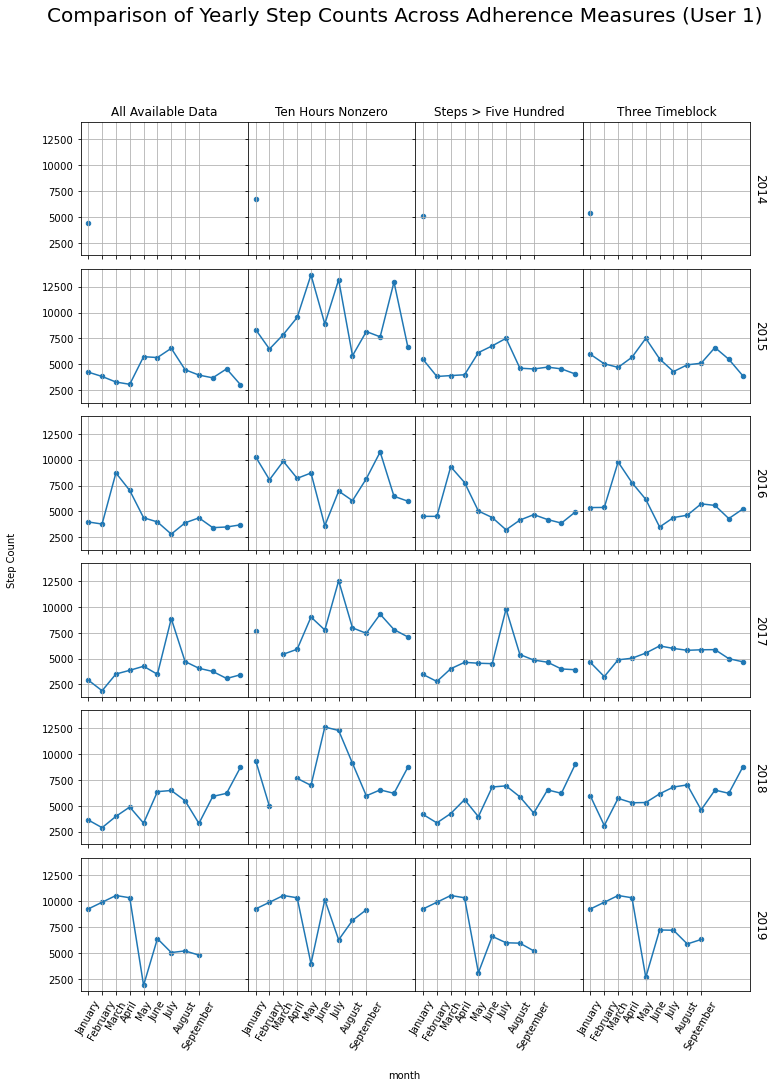

In [11]:
adherence_comparison = {
    'All Available Data': user1_data,
    'Ten Hours Nonzero': user1_data[user1_data['Ten Hours Non Zero']],
    'Steps > Five Hundred': user1_data[user1_data['Steps > Five Hundred']],
    'Three Timeblock': user1_data[user1_data['Three Timeblock']]
}
seasonality_plot(adherence_comparison, resample_by='month', plot_by='year', colour_by=None, agg_method='mean',
                     custom_title='Comparison of Yearly Step Counts Across Adherence Measures (User 1)')

This GIANT plot compares the average steps per month for each year, with each column representing a difference adherence filter: from left to right, we see aggregated steps for the full dataset, ten nonzero hours filter, greater than 500 filter, and the three timeblocks filter. 

Immediately, it's apparrent that filtering for at least ten hours of nonzero steps roundabouts doubles the average step count, which is partially to be expected as it filters out many days of zeroes. How much the baseline step activity shifts up by depends on the level of consistency in their activity-- User1 seems to have many days of no activity, perhaps because they didn't carry their phone around with them, or perhaps they didn't move much. 

The >500 Steps and Three Timeblocks filters evidently don't remove as many days of low step counts as Ten Nonzero. Especially interesting to note is that the Three Timeblocks filter appears to smooth out the user's activity over the year, as it tests for days where the user consistently walked over the course of the day-- i.e. didn't go on a one hour run and then stayed home for the rest of the day. 

Given these graphs, we find the following trends for User1 over the time period:
- 2015: They didn't have their phone consistently for many days, but on the days that they did consistently wear the tracker, they walked around 10,000 steps a day. May and October had the highest consistent activity levels, but the May - July period had more bursts of high activity.
- 2016: Walking peaked in March and steadily declined from there, with June having particularly low tracking time despite having average step counts
- 2017: Not a single day of more than 10 hours of nonzero step count in February, which suggests they may not have gone outside much over that month, or didn't have access to their phone/tracker. They walked a lot and over many days in July but it was in a shorter amount of time (e.g. a hike and then went home and did nothing)
- 2018: March was a month of low wear time, but May through July still goes strong with high wear time and higher than average step counts. 
- 2019: The user was far more consistent in tracking the whole day, given that the step counts look very similar across all adherence measures. This year, March to April emerge as their most active months, with May through July characterised by a sharp fall in walking

---

Now we examine the same comparison for User2, defining a function to speed up the process

In [12]:
def user_comparisons(filepath, user):
    user_data = read_step_data(filepath, "clean")
    conditions, sums = three_method_table(user_data)
    user_data = user_data.resample("D", on='Date')['Steps'].sum()
    user_data = pd.merge(left=user_data, right=conditions, on=['Date'])
    
    adherence_comparison = {
    'All Available Data': user_data,
    'Ten Hours Nonzero': user_data[user_data['Ten Hours Non Zero']],
    'Steps > Five Hundred': user_data[user_data['Steps > Five Hundred']],
    'Three Timeblock': user_data[user_data['Three Timeblock']]
    }
    seasonality_plot(adherence_comparison, resample_by='month', plot_by='year', colour_by=None, agg_method='mean',
                     custom_title=f'Comparison of Yearly Step Counts Across Adherence Measures ({user})')
    

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


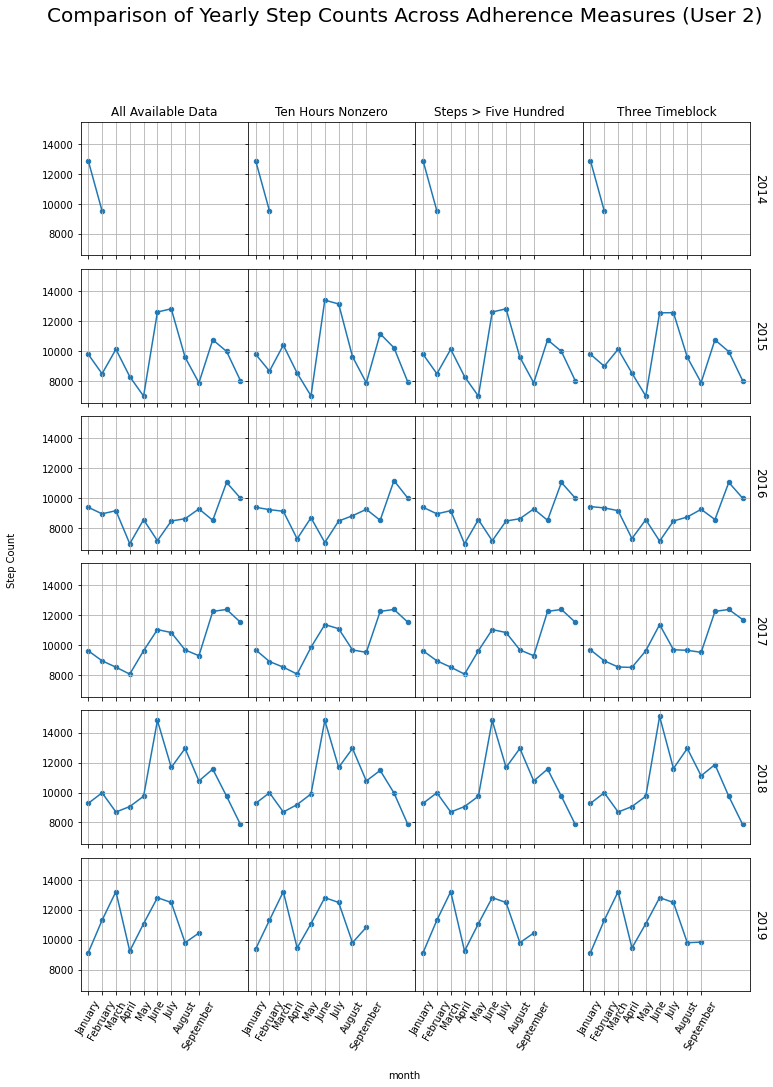

In [14]:
user_comparisons("../../data/cleaned/user2.csv", 'User 2')

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


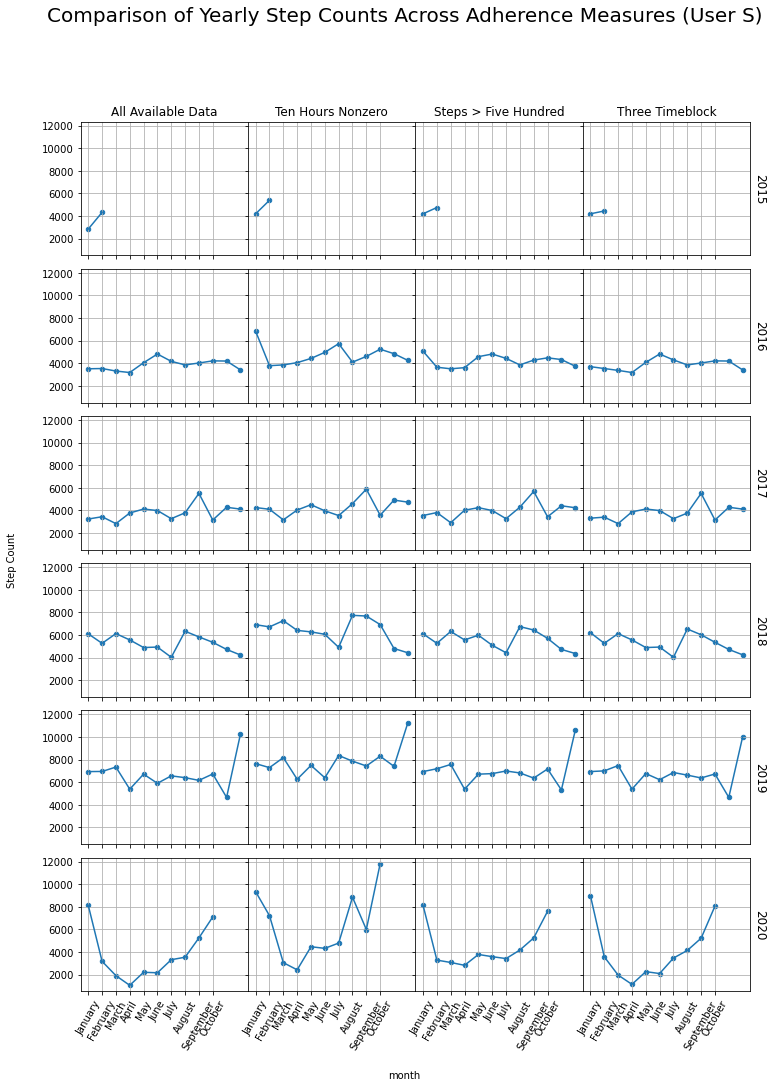

In [16]:
user_comparisons("../../data/cleaned/serena.csv", 'User S')

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


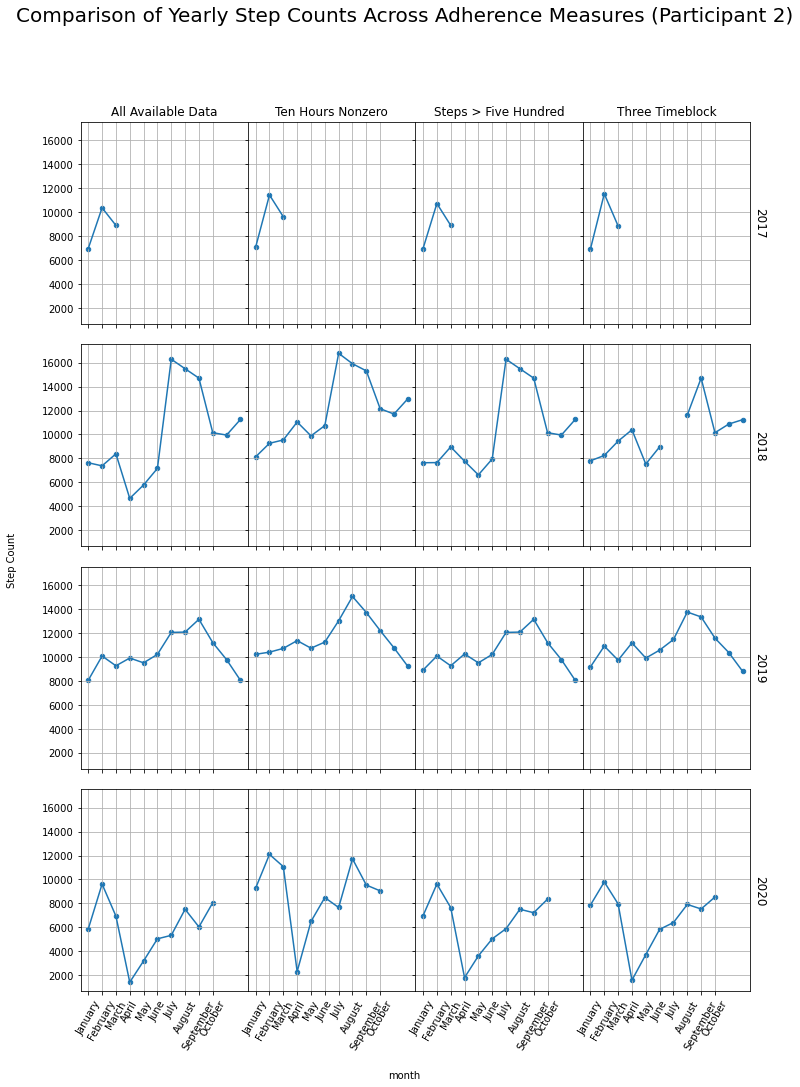

In [17]:
user_comparisons("../../data/cleaned/participant2.csv", 'Participant 2')

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


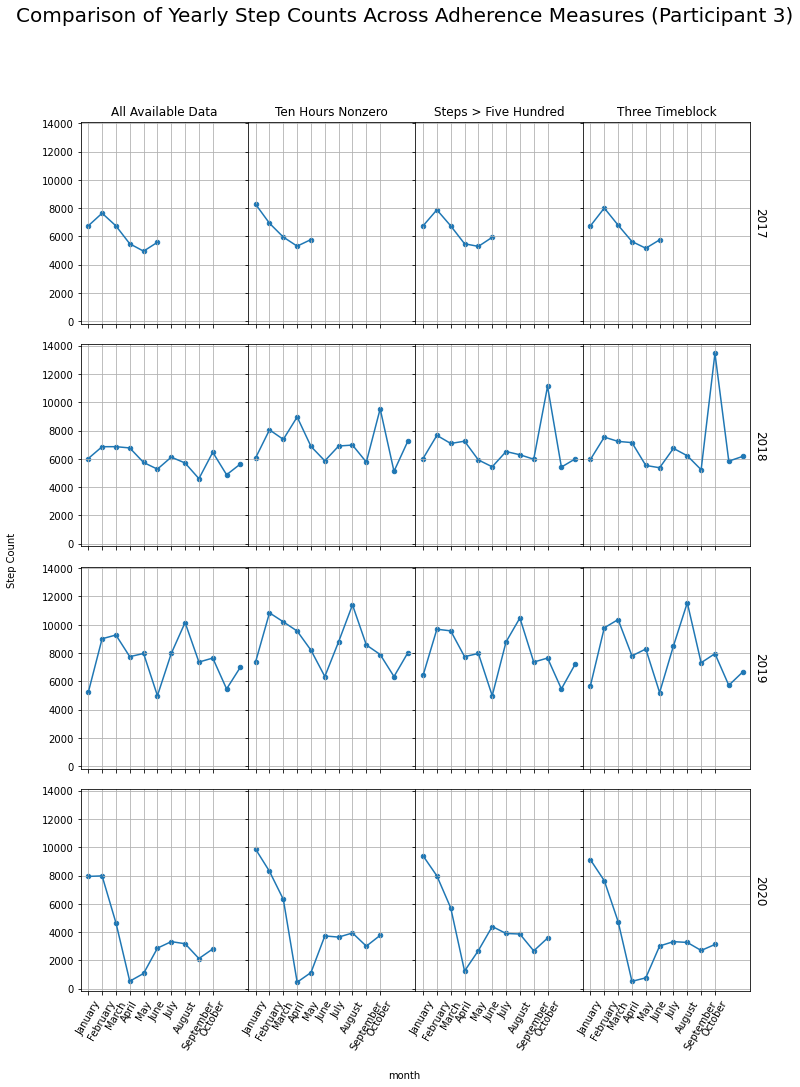

In [18]:
user_comparisons("../../data/cleaned/participant3.csv", 'Participant 3')

/Users/Serena/opt/anaconda3/envs/datasciEnv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/Serena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


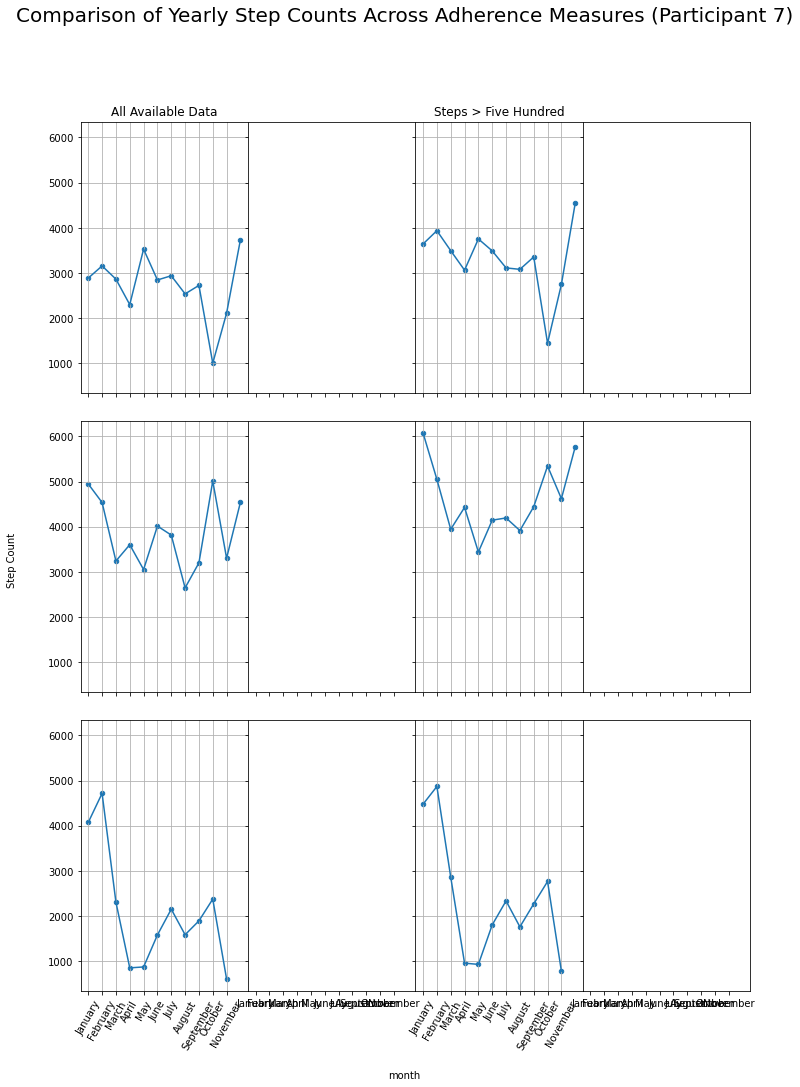

In [19]:
user_comparisons("../../data/cleaned/participant7.csv", 'Participant 7')